In [1]:
import tushare as ts
import pandas as pd
from datetime import datetime, timedelta

In [2]:
TOKEN = "ab8cda03b983bbe19fb5e50cd01c23581fbac2870eac95465b253777"
pro = ts.pro_api(TOKEN)

In [3]:
df = pro.ncov_num(level=2)
len_df = df.shape[0]
df.head()

,ann_date,area_name,parent_name,level,confirmed_num,suspected_num,confirmed_num_now,suspected_num_now,cured_num,dead_num
0,20200124,中国内地,中国,2,830,1072.0,NaN,NaN,34,25
1,20200125,中国内地,中国,2,1287,1965.0,NaN,NaN,38,41
2,20200126,中国内地,中国,2,1975,NaN,NaN,2684.0,49,56
3,20200127,中国内地,中国,2,2744,NaN,NaN,5794.0,51,80
4,20200128,中国内地,中国,2,4515,NaN,NaN,6973.0,60,106


In [4]:
df = df.rename(columns={'ann_date': 'date'})

date_value = list(df["date"])

for idx in range(len(date_value)):
    date_value[idx] = datetime.strftime(
        datetime.strptime(date_value[idx], "%Y%m%d"), "%Y-%m-%d"
    )

df["date"] = date_value

In [5]:
col_n = ['date', 'confirmed_num', 'cured_num', 'dead_num']
df_new = pd.DataFrame(df, columns = col_n)

In [6]:
file_name = "covid-19.csv"
df_new.to_csv("./data/" + file_name, index=None)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers, losses, metrics, callbacks

/Users/FDUHYJ/anaconda3/envs/lisa/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 [Text(-10.0, 0, '2020-03-13'),
  Text(0.0, 0, '2020-01-24'),
  Text(10.0, 0, '2020-02-03'),
  Text(20.0, 0, '2020-02-13'),
  Text(30.0, 0, '2020-02-23'),
  Text(40.0, 0, '2020-03-04'),
  Text(50.0, 0, '2020-03-14'),
  Text(60.0, 0, ''),
  Text(70.0, 0, '')])

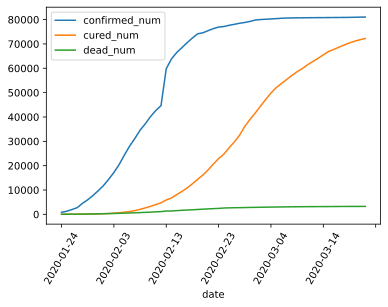

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

df = pd.read_csv("./data/covid-19.csv")
df.plot(x="date", y=["confirmed_num", "cured_num", "dead_num"], figsize=(6, 4))
plt.xticks(rotation=60)

/Users/FDUHYJ/anaconda3/envs/lisa/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


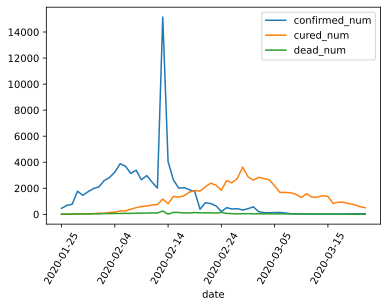

In [9]:
dfdata = df.set_index("date")
dfdiff = dfdata.diff(periods=1).dropna()
dfdiff = dfdiff.reset_index("date")

dfdiff.plot(x="date", y=["confirmed_num", "cured_num", "dead_num"], figsize=(6, 4))
plt.xticks(rotation=60)
dfdiff = dfdiff.drop("date", axis=1).astype("float32")

In [10]:
# 用某日前 8 天窗口数据作为输入预测该日数据
WINDOW_SIZE = 8

def batch_dataset(dataset):
    dataset_batched = dataset.batch(WINDOW_SIZE, drop_remainder=True)
    return dataset_batched

ds_data = tf.data.Dataset.from_tensor_slices(tf.constant(dfdiff.values, dtype=tf.float32)) \
   .window(WINDOW_SIZE, shift=1).flat_map(batch_dataset)

ds_label = tf.data.Dataset.from_tensor_slices(
    tf.constant(dfdiff.values[WINDOW_SIZE:], dtype=tf.float32))

# 数据较小，可以将全部训练数据放入到一个 batch 中，提升性能
ds_train = tf.data.Dataset.zip((ds_data, ds_label)).batch(len_df).cache()

In [11]:
ds_train

<CacheDataset shapes: ((None, 8, 3), (None, 3)), types: (tf.float32, tf.float32)>

In [12]:
# 考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于 0，设计如下结构
class Block(layers.Layer):
    def __init__(self, **kwargs):
        super(Block, self).__init__(**kwargs)

    def call(self, x_input, x):
        x_out = tf.maximum((1 + x) * x_input[:, -1, :], 0.0)
        return x_out

    def get_config(self):  
        config = super(Block, self).get_config()
        return config

In [13]:
tf.keras.backend.clear_session()
x_input = layers.Input(shape=(None, 3), dtype=tf.float32, name="input")
x = layers.LSTM(3, return_sequences=True, input_shape=(None, 3), name="lstm_1")(x_input)
x = layers.LSTM(3, return_sequences=True, input_shape=(None, 3), name="lstm_2")(x)
x = layers.LSTM(3, return_sequences=True, input_shape=(None, 3), name="lstm_3")(x)
x = layers.LSTM(3, input_shape=(None, 3), name="lstm_4")(x)
x = layers.Dense(3)(x)

x = Block()(x_input, x)
model = models.Model(inputs=[x_input], outputs=[x], name="model")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, None, 3)      84          input[0][0]                      
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, None, 3)      84          lstm_1[0][0]                     
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, None, 3)      84          lstm_2[0][0]                     
______________________________________________________________________________________________

In [14]:
# 自定义损失函数，考虑平方差和预测目标的比值
class MSPE(losses.Loss):
    def call(self,y_true,y_pred):
        err_percent = (y_true - y_pred) ** 2 / (tf.maximum(y_true ** 2, 1e-7))
        mean_err_percent = tf.reduce_mean(err_percent)
        return mean_err_percent

    def get_config(self):
        config = super(MSPE, self).get_config()
        return config

In [15]:
import os

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,loss=MSPE(name="MSPE"))

stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join('data', 'autograph', stamp)

tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
# 如果 loss 在 100 个 epoch 后没有提升，学习率减半
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=100)
# 当 loss 在 200 个 epoch 后没有提升，则提前终止训练
stop_callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=200)
callbacks_list = [tb_callback, lr_callback, stop_callback]

history = model.fit(ds_train, epochs=500, callbacks=callbacks_list)

Epoch 1/500
1/1 [==============================] - 0s 56ms/step - loss: 2.6088
Epoch 2/500
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1/1 [==============================] - 0s 12ms/step - loss: 2.4388
Epoch 3/500
1/1 [==============================] - 0s 11ms/step - loss: 2.2655
Epoch 4/500
1/1 [==============================] - 0s 8ms/step - loss: 2.0845
Epoch 5/500
1/1 [==============================] - 0s 13ms/step - loss: 1.8947
Epoch 6/500
1/1 [==============================] - 0s 247ms/step - loss: 1.6961
Epoch 7/500
1/1 [==============================] - 0s 118ms/step - loss: 1.4900
Epoch 8/500
1/1 [==============================] - 0s 17ms/step - loss: 1.2796
Epoch 9/500
1/1 [==============================] - 0s 16ms/step - loss: 1.0705
Epoch 10/500
1/1 [==============================] - 0s 9ms/step - loss: 0.8714
Epoch 11/500
1/1 [==============================] - 0s 35ms/step - loss: 0.6960
Epoch 12/500
1/1 [==============================] - 0s 9m

1/1 [==============================] - 0s 7ms/step - loss: 0.4142
Epoch 100/500
1/1 [==============================] - 0s 12ms/step - loss: 0.4138
Epoch 101/500
1/1 [==============================] - 0s 10ms/step - loss: 0.4134
Epoch 102/500
1/1 [==============================] - 0s 10ms/step - loss: 0.4130
Epoch 103/500
1/1 [==============================] - 0s 9ms/step - loss: 0.4126
Epoch 104/500
1/1 [==============================] - 0s 17ms/step - loss: 0.4122
Epoch 105/500
1/1 [==============================] - 0s 11ms/step - loss: 0.4117
Epoch 106/500
1/1 [==============================] - 0s 9ms/step - loss: 0.4064
Epoch 107/500
1/1 [==============================] - 0s 12ms/step - loss: 0.3981
Epoch 108/500
1/1 [==============================] - 0s 23ms/step - loss: 0.3885
Epoch 109/500
1/1 [==============================] - 0s 44ms/step - loss: 0.3694
Epoch 110/500
1/1 [==============================] - 0s 26ms/step - loss: 0.3570
Epoch 111/500
1/1 [==========================

1/1 [==============================] - 0s 9ms/step - loss: 0.2320
Epoch 201/500
1/1 [==============================] - 0s 12ms/step - loss: 0.2319
Epoch 202/500
1/1 [==============================] - 0s 10ms/step - loss: 0.2317
Epoch 203/500
1/1 [==============================] - 0s 12ms/step - loss: 0.2316
Epoch 204/500
1/1 [==============================] - 0s 11ms/step - loss: 0.2315
Epoch 205/500
1/1 [==============================] - 0s 10ms/step - loss: 0.2313
Epoch 206/500
1/1 [==============================] - 0s 12ms/step - loss: 0.2312
Epoch 207/500
1/1 [==============================] - 0s 10ms/step - loss: 0.2310
Epoch 208/500
1/1 [==============================] - 0s 12ms/step - loss: 0.2309
Epoch 209/500
1/1 [==============================] - 0s 10ms/step - loss: 0.2308
Epoch 210/500
1/1 [==============================] - 0s 10ms/step - loss: 0.2306
Epoch 211/500
1/1 [==============================] - 0s 8ms/step - loss: 0.2305
Epoch 212/500
1/1 [=========================

1/1 [==============================] - 0s 11ms/step - loss: 0.2176
Epoch 302/500
1/1 [==============================] - 0s 13ms/step - loss: 0.2175
Epoch 303/500
1/1 [==============================] - 0s 10ms/step - loss: 0.2174
Epoch 304/500
1/1 [==============================] - 0s 10ms/step - loss: 0.2173
Epoch 305/500
1/1 [==============================] - 0s 10ms/step - loss: 0.2172
Epoch 306/500
1/1 [==============================] - 0s 11ms/step - loss: 0.2171
Epoch 307/500
1/1 [==============================] - 0s 10ms/step - loss: 0.2170
Epoch 308/500
1/1 [==============================] - 0s 10ms/step - loss: 0.2169
Epoch 309/500
1/1 [==============================] - 0s 9ms/step - loss: 0.2168
Epoch 310/500
1/1 [==============================] - 0s 11ms/step - loss: 0.2168
Epoch 311/500
1/1 [==============================] - 0s 11ms/step - loss: 0.2167
Epoch 312/500
1/1 [==============================] - 0s 11ms/step - loss: 0.2166
Epoch 313/500
1/1 [========================

1/1 [==============================] - 0s 9ms/step - loss: 0.2124
Epoch 403/500
1/1 [==============================] - 0s 13ms/step - loss: 0.2124
Epoch 404/500
1/1 [==============================] - 0s 9ms/step - loss: 0.2123
Epoch 405/500
1/1 [==============================] - 0s 11ms/step - loss: 0.2123
Epoch 406/500
1/1 [==============================] - 0s 10ms/step - loss: 0.2123
Epoch 407/500
1/1 [==============================] - 0s 11ms/step - loss: 0.2122
Epoch 408/500
1/1 [==============================] - 0s 25ms/step - loss: 0.2122
Epoch 409/500
1/1 [==============================] - 0s 10ms/step - loss: 0.2122
Epoch 410/500
1/1 [==============================] - 0s 13ms/step - loss: 0.2122
Epoch 411/500
1/1 [==============================] - 0s 11ms/step - loss: 0.2121
Epoch 412/500
1/1 [==============================] - 0s 9ms/step - loss: 0.2121
Epoch 413/500
1/1 [==============================] - 0s 12ms/step - loss: 0.2121
Epoch 414/500
1/1 [==========================

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, train_metrics, 'bo--', markersize=2, linewidth=1)
    plt.title('Training '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric])
#     plt.show()

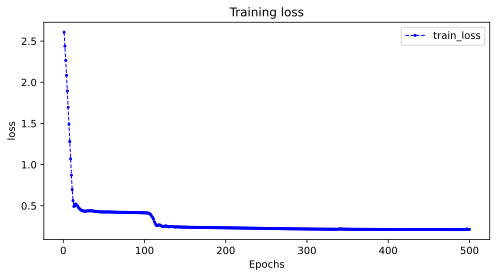

In [17]:
plot_metric(history, "loss")

In [18]:
# 使用 dfresult 记录现有数据以及此后预测的疫情数据
dfresult = dfdiff[["confirmed_num", "cured_num", "dead_num"]].copy()
dfresult.tail()

,confirmed_num,cured_num,dead_num
53,13.0,922.0,11.0
54,34.0,819.0,8.0
55,39.0,730.0,3.0
56,41.0,590.0,7.0
57,46.0,504.0,6.0


In [19]:
# 预测此后 200 天的新增走势，将其结果添加到 dfresult 中
for i in range(200):
    arr_predict = model.predict(tf.constant(tf.expand_dims(dfresult.values[- len_df:, :], axis = 0)))

    dfpredict = pd.DataFrame(tf.cast(tf.floor(arr_predict), tf.float32).numpy(),
                columns=dfresult.columns)
    dfresult = dfresult.append(dfpredict, ignore_index=True)

In [20]:
base_date = datetime.strptime("2020-01-24", "%Y-%m-%d")

In [21]:
dfresult.query("confirmed_num==0").head()

,confirmed_num,cured_num,dead_num
66,0.0,277.0,0.0
67,0.0,259.0,0.0
68,0.0,242.0,0.0
69,0.0,226.0,0.0
70,0.0,211.0,0.0


In [32]:
no_confirmed_date = base_date + timedelta(
    days=int(dfresult.query("confirmed_num==0").index[0] + 1)
)

print(datetime.strftime(no_confirmed_date, "%Y-%m-%d"))

2020-03-31


In [23]:
dfresult.query("cured_num==0").head()

,confirmed_num,cured_num,dead_num
108,0.0,0.0,0.0
109,0.0,0.0,0.0
110,0.0,0.0,0.0
111,0.0,0.0,0.0
112,0.0,0.0,0.0


In [33]:
no_cured_date = base_date + timedelta(
    days=int(dfresult.query("cured_num==0").index[0] + 1)
)

print(datetime.strftime(no_cured_date, "%Y-%m-%d"))

2020-05-12


In [25]:
dfresult.query("dead_num==0").head()

,confirmed_num,cured_num,dead_num
60,13.0,415.0,0.0
61,8.0,388.0,0.0
62,5.0,363.0,0.0
63,3.0,339.0,0.0
64,2.0,317.0,0.0


In [34]:
no_dead_date = base_date + timedelta(
    days=int(dfresult.query("dead_num==0").index[0] + 1)
)

print(datetime.strftime(no_dead_date, "%Y-%m-%d"))

2020-03-25


In [27]:
model.save('./data/tf_model_savedmodel', save_format="tf")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./data/tf_model_savedmodel/assets


In [28]:
model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel', compile=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_loaded.compile(optimizer=optimizer, loss=MSPE(name = "MSPE"))
model_loaded.predict(ds_train)

array([[1.31635791e+03, 9.41352158e+01, 3.28035593e+00],
       [1.62365442e+03, 7.38105698e+01, 6.67005730e+00],
       [1.77165845e+03, 1.57248596e+02, 6.23267651e+00],
       [2.02752991e+03, 1.67945786e+02, 6.99809265e+00],
       [2.43704956e+03, 2.78126770e+02, 7.10743809e+00],
       [2.31663940e+03, 2.79196503e+02, 7.98219967e+00],
       [1.97108765e+03, 4.13981018e+02, 7.98219967e+00],
       [2.12285449e+03, 5.45556335e+02, 9.40368652e+00],
       [1.66316406e+03, 6.40761292e+02, 9.73172283e+00],
       [1.86447461e+03, 6.76062012e+02, 1.06064844e+01],
       [1.54714392e+03, 7.64848633e+02, 1.18092813e+01],
       [1.26367859e+03, 7.95870483e+02, 1.06064844e+01],
       [9.50173340e+03, 1.25264026e+03, 2.77736797e+01],
       [2.53801831e+03, 8.68611328e+02, 1.42148757e+00],
       [1.65626550e+03, 1.46872327e+03, 1.56363630e+01],
       [1.25928857e+03, 1.41523743e+03, 1.55270176e+01],
       [1.28437402e+03, 1.52434863e+03, 1.14812460e+01],
       [7.57791626e+02, 1.81346